# Lesson 3 - Image Classification
In this lesson we will create a model to solve an image classification problem. Again we will use a standard Dataset to do this. First we will build a model that classifies hand-written digits; this is the classic MNIST dataset, it is somewhat old and generally considered straightforward to solve by today's standards. However, it's a good teaching dataset.

This lesson with introduce some new concepts:
- Accuracy - this is a measure of how good our model is based on the avaialble data
- Training Vs Test Datasets
- Multi-Layer Neural Networks
- How we learn from images

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import os__|This is a standard Python library to work with the file system|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import pandas as pd__|Pandas is a library that helps us manipulate tables of data. We import this|
|__import seaborn as sns__|Seaborn is a library that created very useful visualisations|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
| __import lesson3__ |This is a Python libary that contains various functions used and are specific to this workbook. You can look at this code in the GitHub repo (file name _lesson3.py_)|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [2]:
# Import the packages we need
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import lesson3

%matplotlib inline

## Training and Test Data Sets
When we build Neural Networks we don't just want the model to memorise the examples (data) we provide but instead we want the model to be able to generalise to new examples that it has never seen before.

So we need to split our available data into two sets (for the time being):
- __Training Dataset__ - this data is used purely to train the model
- __Test Dataset__ - this data is NEVER used to train the model only to test how good the model is.

Typically our Training Dataset contains most of our available data and the Test Dataset is much smaller since we want to train on as much data as possible. Some literature suggests an 80:20 split between Train:Test but others suggest split such as 90:10 or 95:5.

### Exercise
Imagine we have 1,000 examples and decide to split them 80:20 so we take the first 800 examples as our Training Dataset and that last 200 records as our Test Dataset.

- Why might this be a poor way to split the data?
- What properties of the data do you think are important to have in both Training and Testing datasets?
- What would be some good ways to split the available data?

## The MNIST Dataset
When building our model we are using the Tensorflow and Keras libraries (APIs) and these provide easy access to datasets such as MNIST and even pre-split the data into training and testing sets.

Each of the hand written digits is quite small, only 28 x 28 pixels and they are greyscale (i.e. not color).

Let's import the data and have a look at some examples.

In [3]:
# The data is loaded and pre-allocated into Training and Testing dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

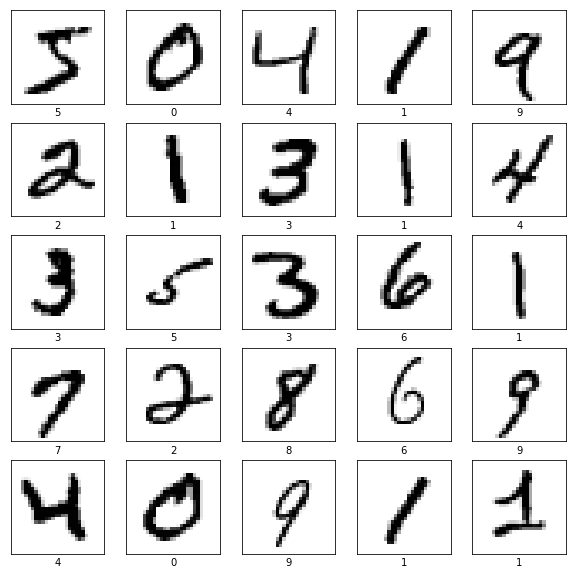

In [4]:
# Display some of the Training Data samples
lesson3.printSampleImages(x_train, y_train)

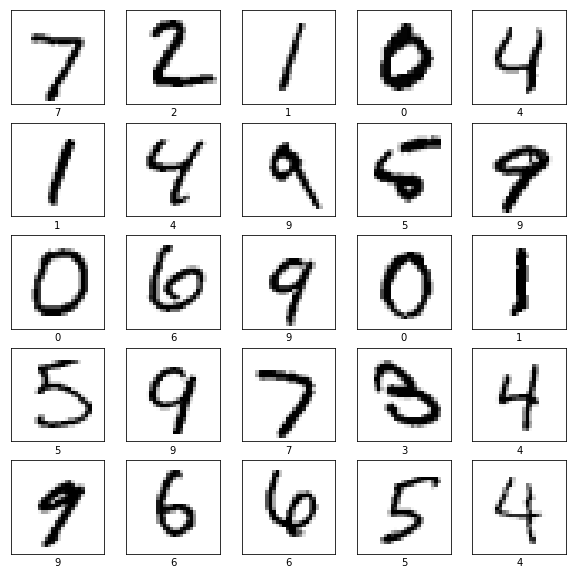

In [5]:
# Display some of the Testing Data samples
lesson3.printSampleImages(x_test, y_test)

## Exercise
If you take a digit such as the number 3 - How would you define a set of rules that describe how to recognise the number 3?


## What does this data look like to a computer
When we view the image we see the shape, position of the image and recognise it as a particualr number. However Computers don't have eyes like we do so how does it learn to recognise and classify these images?

The images we have loaded as our data are represented as a sequence of numbers and it is these numbers and patterns of numbers that computer will use to _learn how to recognise_ the written digit.

So here is what the computer will see

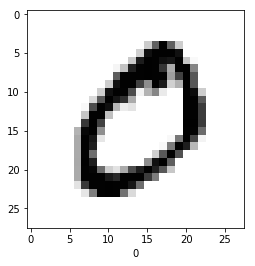

In [6]:
image_id = 1
lesson3.printSingleImage(x_train, y_train, image_id)

In [7]:
print(x_train[image_id][15])

[  0   0   0   0   0   0  76 246 252 112   0   0   0   0   0   0   0   0
   0   0 253 252 148   0   0   0   0   0]


## The problem with Multiplicaiton
Currently our numbers are in the range 0 to 255 (greyscale) but since NNs use multiplication we can end up with our weights and biases becomming very small (known as the Vanishing Gradient problem) so we tend to Normalise our data into the range 0 to 1

While this changes the values it shouldn't change the meaning of the values. In the case of our image data, it will just make them a bit lighter.

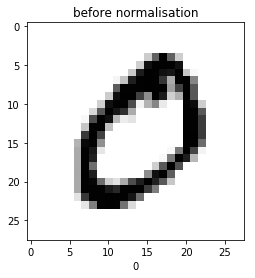

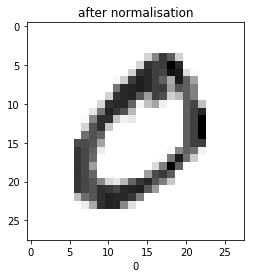

In [8]:
lesson3.printSingleImage(x_train, y_train, image_id, title="before normalisation")

# Normalise the data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

lesson3.printSingleImage(x_train, y_train, image_id, title="after normalisation")

In [9]:
# The raw data looks like this
np.set_printoptions(precision=3)
print(x_train[image_id][15])

[0.    0.    0.    0.    0.    0.    0.34  0.34  0.324 0.173 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.303 0.361 0.363 0.
 0.    0.    0.    0.   ]


## Our Model
In our previous lesson we _predicted_ a numerical value (MPG) from a set of distinct inputs; in this workbook we are not trying to predict a value but instead we want to classify an image as being a digit (0, 1, 2, ... 8, or 9) from an image of a handwritten digit (measuring 28 x 28 pixels).

As an intial model we will take our 28x28 pixel values and convert this into a single list of values (784 inputs). This process is known as __Flattening__ and _Keras_ provides us with a special layer that does this for us.

With this flattened data we will have a set of Hidden Layers to try and learn the mapping between the image pixels and the digit classification.

Lastly we will have an output layer that predicts the classification; because we have 10 classes (1 for each digit) we will have an output layer with 10 units but we will use an _activation function_ called _softmax_ which works well for classification problems.

Let's see what this model looks like

In [15]:
model  = tf.keras.Sequential()

# Input Layer
# This layer flattens our 28x28 images into a stream of 784 numbers
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))

# Hidden Layers
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))

# Output Layer
# We have 10 classes so we need 10 nodes in our output
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# Compile the model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


As before we will train our model for a number of epochs and then evaluate how good the model is

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(x_train, y_train, epochs=50, validation_split = 0.2, callbacks=[early_stop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 88us/sample - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0134 - val_acc: 0.9964
Epoch 2/20
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0063 - acc: 0.9981 - val_loss: 0.0144 - val_acc: 0.9962
Epoch 3/20
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0117 - val_acc: 0.9967
Epoch 4/20
48000/48000 [==============================] - 4s 83us/sample - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0125 - val_acc: 0.9966
Epoch 5/20
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0080 - acc: 0.9977 - val_loss: 0.0109 - val_acc: 0.9968
Epoch 6/20
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0260 - val_acc: 0.9937
Epoch 7/20
48000/48000 [==============================] - 5s 96us/sample - loss: 0.0051 - acc: 0.9983 - val_loss: 0.

## Evaluate the model
This is where our __Test Dataset__ comes in, we will use this dataset to evaluate how well our model does on data it's not seen before. 

This is a good indicator of how well our model generalises to previously unseen data.

We really want our Validation Accuracy to be close to our Training Accuracy.

In [20]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print ("Validation Loss:", val_loss)
print ("Validation Accuracy:", val_acc)

10000/10000 [==============================] - 0s 40us/sample - loss: 0.1681 - acc: 0.9790
Validation Loss: 0.16805017199532796
Validation Accuracy: 0.979


### Exercise
Run the cell below to produce a graph of the Training Accuracy and Loss during training, look at the graph and then answer the following questions?

Remember:
- __Training Loss__ is a measure of how well the predicted values match the expected values for the data used to train the model
- __Training Accuracy__ is the percentage of how training images the model correctly classified.

- What pattern do you you observe?
- Do you think if we train for longer we will improve the accuracy?
    - If you are not sure try re-running the cell above where we trained our model and see what happens

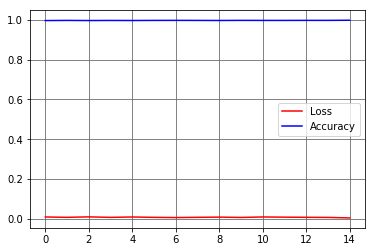

In [22]:
# summarize history for loss and accuracty across epochs
lesson3.displayLossAndAccuracy(history)

### Exercise: Is this good enough?
So our __Accuracy__ against previously unseen data is about 95% but how do we know if this is any good? One way is to consider how well a Human might do on the same task (__Human Level Performance__)

If you were asked to categorise the hand written digits, would you be 100% accurate? If not what percentage do you think you would achieve?

Discuss this in groups to:
1. Agree on an accuracy percentage for Human Level Performance on this task.
2. List some problems you think a Human might have with this task.

# What is our model getting wrong
Let's look at what our model is getting wrong to see if we think this is acceptable errors or not when compared to Human Level Performance.

One way to investigate this is to look at the what our model is getting wrong at a class level. We can use a __Confusion Matrix__ for this purpose. A _Confusion Matrix_ displays how our model performed against the expected outcomes. 

In a good model we should see high values on the leading diagonal (left to right diagonal) and much lower values everywhere else.

Let's generate a Confusion Matrix.

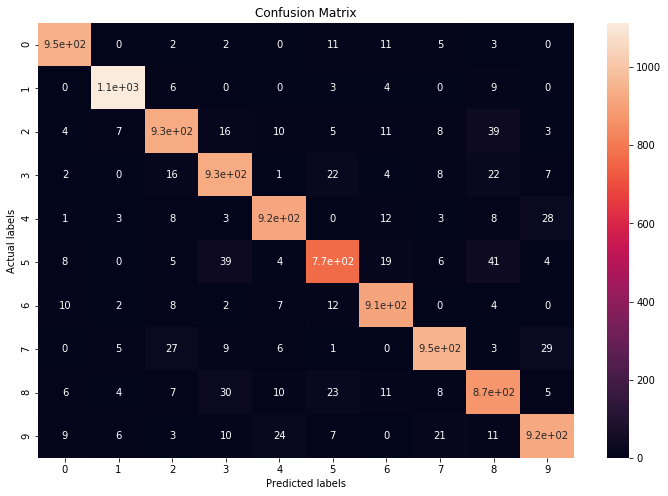

In [13]:
# Generate our predictions
test_predictions = model.predict_classes(x_test)

# Display a Confusion Matrix
lesson3.displayConfusionMatrix(y_test, test_predictions)

### Exercise
Examine the _Confusion Matrix_ above - our model has made some classification mistakes. Look at the higher values and consider:
- Which _confusions_ are ones that a Human is likely to make sometimes
- Which _confusions_ are ones that a Human is unlikely to make often
- Which _confusions_ are ones that a Human is highly unlikely to ever make

### What images are confusing our model
Another approach is to view the images that the model is confused on and see if we think these are genuine mistakes or something else.

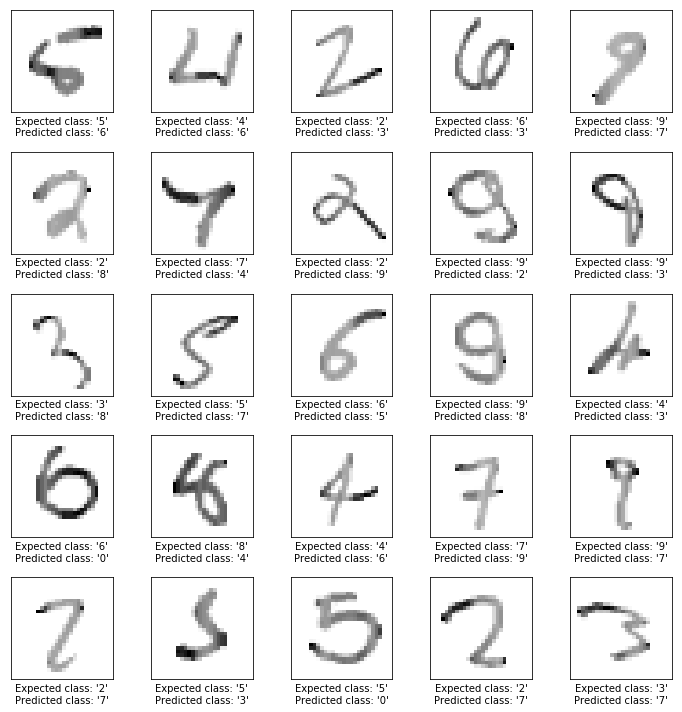

In [14]:
lesson3.printSampleIncorrectImages(x_test, y_test, single_layer_model)

# Key Observations
The following are key observations to note before we move on
1. An NNs learn to classify images in a very different way to humans
    - More generally, NNs learn differently to humans
    - In this example we treated the image as a sequence of numbers so lost some spacial information.
    - The learning is based purely on numerical values and computations
    - __BUT__ that doesn't mean it's not useful
2. Deeper Networks tend to have a greater capacity to learn more complex relationships between inputs and outputs.
3. We need to _test_ our model on unseen data to get a better idea of how well it has trained
4. Simple metrics such as Accuracy are good indicators but further investigation and testing may be required.
5. Sometimes machines struggle to classify correctly the same as a human.
    - They fail in ways that a human wouldn't